#CODIGO


https://www.kaggle.com/datasets/jainilcoder/netflix-stock-price-prediction

In [1]:
# =============================================================================
# 1. Instalação e Importação das Bibliotecas
# =============================================================================
from google.colab import drive
drive.mount('/content/drive')

# Instale as dependências necessárias (execute se ainda não estiverem instaladas)
!pip install prophet
!pip install pandas numpy matplotlib scikit-learn tensorflow keras

# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prophet para previsão de séries temporais
from prophet import Prophet

# Bibliotecas para o modelo LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Para normalização e métricas
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# =============================================================================
# 2. Leitura e Preparação dos Dados
# =============================================================================
# Carregue o dataset utilizando o caminho fornecido
caminho_arquivo = '/content/drive/MyDrive/Ponderadas/NFLX.csv'
df = pd.read_csv(caminho_arquivo, parse_dates=['Date'])

# Ordena os dados pela data, se necessário
df.sort_values(by='Date', inplace=True)
print("Visualizando as 5 primeiras linhas do dataset:")
print(df.head())

# Selecionaremos a coluna 'Close' para a previsão.


Visualizando as 5 primeiras linhas do dataset:
        Date        Open        High         Low       Close   Adj Close  \
0 2018-02-05  262.000000  267.899994  250.029999  254.259995  254.259995   
1 2018-02-06  247.699997  266.700012  245.000000  265.720001  265.720001   
2 2018-02-07  266.579987  272.450012  264.329987  264.559998  264.559998   
3 2018-02-08  267.079987  267.619995  250.000000  250.100006  250.100006   
4 2018-02-09  253.850006  255.800003  236.110001  249.470001  249.470001   

     Volume  
0  11896100  
1  12595800  
2   8981500  
3   9306700  
4  16906900  


In [3]:
# =============================================================================
# 3. Modelo de Previsão com Prophet
# =============================================================================
# 3.1 Preparação dos Dados para o Prophet
# Crie um dataframe específico com as colunas necessárias:
df_prophet = df[['Date', 'Close']].copy()
# O Prophet requer que as colunas sejam nomeadas como 'ds' (data) e 'y' (valor)
df_prophet.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

# Divida os dados em treino (80%) e teste (20%)
train_size = int(len(df_prophet) * 0.8)
train_data = df_prophet.iloc[:train_size]
test_data = df_prophet.iloc[train_size:]

print("Total de registros:", len(df_prophet))
print("Registros de treino:", len(train_data))
print("Registros de teste:", len(test_data))


Total de registros: 1009
Registros de treino: 807
Registros de teste: 202


In [4]:
# 3.2 Treinamento do Modelo Prophet
# Cria e treina o modelo com sazonalidade diária
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(train_data)

# Crie um DataFrame com datas futuras para previsão, usando o mesmo número de pontos do teste
future = model_prophet.make_future_dataframe(periods=len(test_data), freq='D')
forecast = model_prophet.predict(future)

# Exibe as últimas linhas da previsão
print("Previsão final com Prophet:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


DEBUG:cmdstanpy:input tempfile: /tmp/tmp1z27uyyu/qn9qx2tt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp1z27uyyu/anjhja__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72477', 'data', 'file=/tmp/tmp1z27uyyu/qn9qx2tt.json', 'init=/tmp/tmp1z27uyyu/anjhja__.json', 'output', 'file=/tmp/tmp1z27uyyu/prophet_modelwrufdnt0/prophet_model-20250330232240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:22:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:22:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Previsão final com Prophet:
             ds        yhat  yhat_lower  yhat_upper
1004 2021-11-04  596.791200  527.588191  663.192354
1005 2021-11-05  594.630515  523.779073  667.293706
1006 2021-11-06  590.735725  523.257306  660.500239
1007 2021-11-07  590.571252  522.573403  658.814009
1008 2021-11-08  594.046791  523.095512  664.891161


In [5]:
# 3.3 Avaliação do Modelo Prophet
# Mesclar os dados do teste com as previsões
df_merged = pd.merge(test_data, forecast[['ds', 'yhat']], on='ds', how='left')

# Verificar a quantidade de NaN em cada coluna
print("NaN em cada coluna:\n", df_merged.isna().sum())

# Remover linhas com NaN
df_merged = df_merged.dropna()

# Extrair os valores reais e previstos
y_true_prophet = df_merged['y'].values
y_pred_prophet = df_merged['yhat'].values

# Calcular as métricas de erro
rmse_prophet = np.sqrt(mean_squared_error(y_true_prophet, y_pred_prophet))
mae_prophet = mean_absolute_error(y_true_prophet, y_pred_prophet)

print("RMSE (Prophet):", rmse_prophet)
print("MAE  (Prophet):", mae_prophet)



NaN em cada coluna:
 ds       0
y        0
yhat    61
dtype: int64
RMSE (Prophet): 69.21637498843667
MAE  (Prophet): 62.61444861628253


In [6]:
# =============================================================================
# 4. Modelo de Previsão com LSTM
# =============================================================================
# 4.1 Preparação dos Dados para LSTM
# Utilizaremos apenas a coluna 'Close'
df_lstm = df[['Date', 'Close']].copy()
df_lstm.set_index('Date', inplace=True)

# Converta os dados para um array NumPy
data = df_lstm.values

# Normalização dos dados utilizando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Função para criar sequências de dados (janela de tempo)
def create_sequences(dataset, window_size=30):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

window_size = 30  # número de dias anteriores para prever o próximo
X, y = create_sequences(scaled_data, window_size)

# Divida os dados em treino (80%) e teste (20%)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Redimensione os dados para o formato [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test,  (X_test.shape[0],  X_test.shape[1],  1))

print("Formato dos dados para LSTM:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)


Formato dos dados para LSTM:
X_train: (783, 30, 1) X_test: (196, 30, 1)


In [11]:
# 4.2 Construção e Treinamento do Modelo LSTM
model_lstm = Sequential()
# Primeira camada LSTM com 50 unidades e retorno de sequências
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model_lstm.add(Dropout(0.2))
# Segunda camada LSTM sem retorno de sequências
model_lstm.add(LSTM(50, return_sequences=False))
model_lstm.add(Dropout(0.2))
# Camada densa de saída
model_lstm.add(Dense(1))

# Compilação do modelo utilizando o otimizador 'adam' e erro quadrático médio
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()

# Treinamento do modelo
history = model_lstm.fit(
    X_train, y_train,
    epochs=20,          # número de épocas (pode ser ajustado)
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 30, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0431 - val_loss: 0.0130
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - val_loss: 0.0052
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - val_loss: 0.0055
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Métricas do modelo LSTM:
RMSE (LSTM): 29.698779697016334
MAE  (LSTM): 20.196007997419084


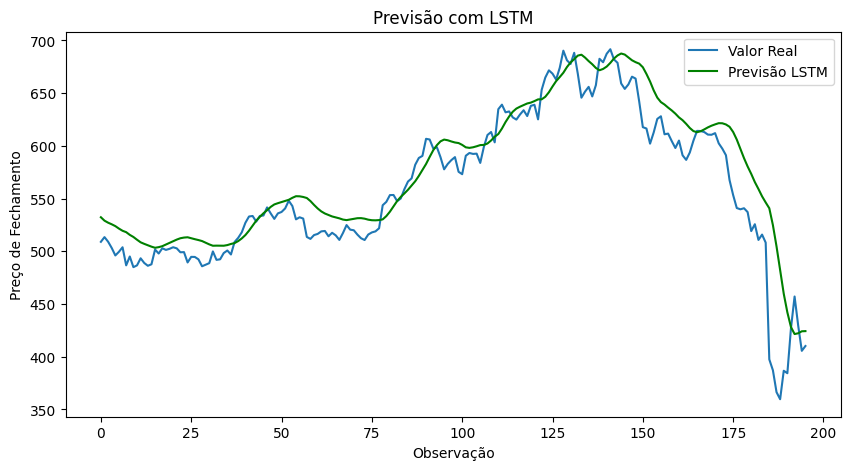

In [12]:
# 4.3 Avaliação do Modelo LSTM
# Previsão com os dados de teste
predictions = model_lstm.predict(X_test)

# Inverte a normalização para comparar com os valores reais
predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Cálculo das métricas de erro
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
mae_lstm = mean_absolute_error(y_test_inv, predictions_inv)

print("Métricas do modelo LSTM:")
print("RMSE (LSTM):", rmse_lstm)
print("MAE  (LSTM):", mae_lstm)

# Plotando a previsão do LSTM comparada aos dados reais
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Valor Real')
plt.plot(predictions_inv, label='Previsão LSTM', color='green')
plt.xlabel('Observação')
plt.ylabel('Preço de Fechamento')
plt.title('Previsão com LSTM')
plt.legend()
plt.show()


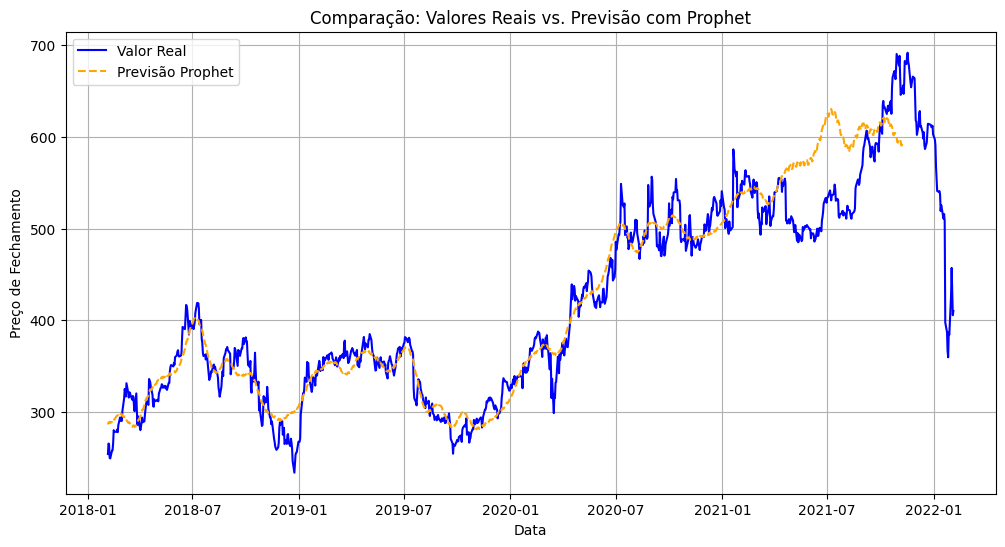

In [14]:
# =============================================================================
# Gráfico: Valores Reais vs. Previsão com Prophet
# =============================================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
# Plot dos valores reais
plt.plot(df_prophet['ds'], df_prophet['y'], label='Valor Real', color='blue')
# Plot das previsões do Prophet
plt.plot(forecast['ds'], forecast['yhat'], label='Previsão Prophet', color='orange', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.title('Comparação: Valores Reais vs. Previsão com Prophet')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# =============================================================================
# 5. Comparação das Métricas e Justificativa da Escolha
# =============================================================================
print("Comparação das métricas de erro:")
print("Prophet - RMSE: {:.4f} | MAE: {:.4f}".format(rmse_prophet, mae_prophet))
print("LSTM    - RMSE: {:.4f} | MAE: {:.4f}".format(rmse_lstm, mae_lstm))

Comparação das métricas de erro:
Prophet - RMSE: 69.2164 | MAE: 62.6144
LSTM    - RMSE: 29.6988 | MAE: 20.1960


#JUSTIFICATIVA


**Justificativa da Escolha das Métricas MAE e RMSE**

Para avaliar a performance dos modelos de previsão (Prophet e LSTM), foram adotadas duas métricas importantes: **MAE (Mean Absolute Error)** e **RMSE (Root Mean Squared Error)**. Essas métricas são amplamente utilizadas na área de previsão de séries temporais, conforme destacado na literatura, como em *Forecasting: Principles and Practice* (Hyndman & Athanasopoulos, 2018).

1. **MAE (Erro Médio Absoluto)**
   - **O que é?**  
     O MAE é calculado como a média dos valores absolutos das diferenças entre as previsões e os valores observados.
   - **Por que usar?**  
     Ele fornece uma medida intuitiva do erro médio, já que seus valores estão na mesma unidade dos dados originais. Isso facilita a interpretação prática do quão distante, em média, as previsões estão dos valores reais, sem dar peso exagerado aos erros maiores.

2. **RMSE (Raiz do Erro Quadrático Médio)**
   - **O que é?**  
     O RMSE é obtido a partir da raiz quadrada da média dos quadrados das diferenças entre as previsões e os valores reais.
   - **Por que usar?**  
     Ao elevar os erros ao quadrado antes de calcular a média, essa métrica penaliza mais severamente os erros maiores. Essa característica é útil em contextos onde desvios significativos podem causar impactos maiores ou quando se deseja dar mais ênfase aos grandes erros.

**Em resumo:**  
- **MAE** oferece uma visão direta do erro médio, facilitando a interpretação prática, pois os valores estão na mesma escala dos dados.
- **RMSE** enfatiza os erros mais elevados, ajudando a identificar quando o modelo comete desvios grandes.

Utilizar ambas as métricas permite obter uma avaliação mais completa do desempenho dos modelos, fornecendo insights sobre tanto o erro médio quanto a magnitude dos desvios maiores.

**Referência:**  
Hyndman, R. J., & Athanasopoulos, G. (2018). *Forecasting: Principles and Practice* (2ª ed.). Disponível em: [https://otexts.com/fpp3/](https://otexts.com/fpp3/)

---